<div style="text-align: center; font-size: 46px; font-weight: bold;">
  Dynamics of the implied volatility skew
</div>

# <u>STEP 1</u>: Literature Review.
https://wilmott.com/managing-smile-risk/ <br> https://mfe.baruch.cuny.edu/wp-content/uploads/2013/01/OsakaSVI2012.pdf <br> https://arxiv.org/abs/1204.0646 <br> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4428407 <br> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4174538

# <u>STEP 2</u>: Skew Estimations.

The goal of this step is to compute skew measures using different methods (spline, polynomial, SVI, SABR) and to retain the most robust ones in order to obtain a reliable proxy for subsequent steps.

## 2.1 Data Extraction & Cleaning:

In [3]:
# Import libraries
import pandas as pd
import numpy as np

In [4]:
def load_vol_surface(file_path, index):
    
    # Load the raw Excel sheet
    raw_df = pd.read_excel(file_path, sheet_name=index, header=None)

    # --- Extract metadata and implied vol surface ---
    spot_price = float(raw_df.iloc[3, 4]) # E4
    interest_rate = float(raw_df.iloc[1, 10]) # K2
    dividend_rate = float(raw_df.iloc[2, 10]) # K3
    strikes = raw_df.iloc[7, 3:12].astype(float).values # Row 8, D to L
    maturities = raw_df.iloc[8:21, 2].values # Row 9–21, Column C
    vol_matrix = raw_df.iloc[8:21, 3:12].astype(float).values / 100.0 # Row 9–21, D to L

    # --- Helper to convert maturity string to year fraction ---
    def maturity_to_years(maturity_str):
        if 'M' in maturity_str:
            return int(maturity_str.replace('M', '')) / 12
        elif 'Y' in maturity_str:
            return int(maturity_str.replace('Y', ''))
        else:
            raise ValueError(f"Unknown maturity format: {maturity_str}")

    # --- Reshape into long-format DataFrame ---
    data = pd.DataFrame([
        {
            'maturity': maturities[i],
            'T': maturity_to_years(maturities[i]),
            'strike': strikes[j],
            'moneyness': strikes[j] / spot_price,
            'implied_vol': vol_matrix[i, j] # Already in %
        }
        for i in range(len(maturities))
        for j in range(len(strikes))
    ])
    data['spot'] = spot_price
    data['r'] = interest_rate
    data['q'] = dividend_rate
    data['index'] = index

    return data

In [8]:
# Load SPX-2014 vol surface into a DataFrame and display a preview
spx2014_df = load_vol_surface(file_path='data/market_data.xlsx', index='SPX-2014')
spx2014_df.head(3)

,maturity,T,strike,moneyness,implied_vol,spot,r,q,index
0,1M,0.083333,1560.928,0.80,0.2698,1951.16,0.014,0.0226,SPX-2014
1,1M,0.083333,1756.044,0.90,0.1820,1951.16,0.014,0.0226,SPX-2014
2,1M,0.083333,1853.602,0.95,0.1337,1951.16,0.014,0.0226,SPX-2014


In [9]:
# Load other index/year vol surfaces into DataFrames
spx2015_df = load_vol_surface(file_path='data/market_data.xlsx', index='SPX-2015')
ndx2014_df = load_vol_surface(file_path='data/market_data.xlsx', index='NDX-2014')
ndx2015_df = load_vol_surface(file_path='data/market_data.xlsx', index='NDX-2015')

## 2.2 Quadratic Spline Method (MATLAB-style interpolation):

In [12]:
from scipy.interpolate import UnivariateSpline

In [13]:
def compute_atmf_skew_spline(df):
    
    results = []

    for maturity in df['maturity'].unique():
        sub = df[df['maturity']==maturity].sort_values('strike')
        K   = sub['strike'].values
        σ   = sub['implied_vol'].values
        spot, r, q = sub[['spot','r','q']].iloc[0]
        T = sub['T'].iloc[0]

        # Compute forward price
        F = spot * np.exp((r-q)*T)

        # Fit a quadratic spline (interpolates all points)
        k = np.log(K / F) # work in log‐moneyness
        spline_k = UnivariateSpline(k, σ, k=2, s=0)

        # ∂σ/∂k at k = log(K/F) = 0 (ATM-forward)
        skew_k = spline_k.derivative()(0)

        results.append({
            'maturity': maturity,
            'T': T,
            'forward': F,
            'atmf_skew': skew_k,
            'abs_skew': abs(skew_k),
            'index': sub['index'].iloc[0],
        })

    return pd.DataFrame(results).sort_values('T')

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_spline_skew(skew_df):
    plt.figure(figsize=(10, 6))
    plt.plot(skew_df['T'], skew_df['abs_skew'], 'o-', color='red', label='|ATMF skew| (spline)')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Absolute ATMF Skew")
    plt.title(f"{skew_df['index'].iloc[0]} - Term Structure of SPX ATMF Skew (Spline Method)")
    plt.grid(True)
    plt.legend()
    plt.show()

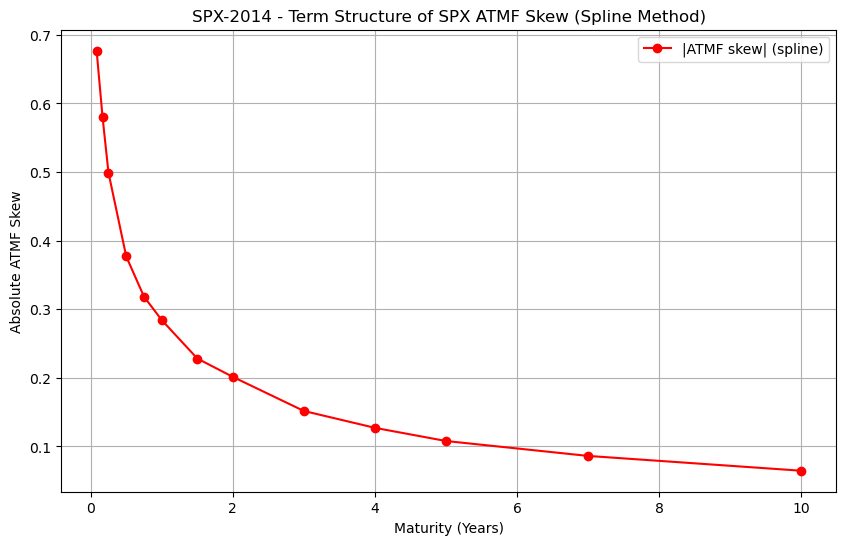

,maturity,T,forward,atmf_skew,abs_skew,index
0,1M,0.083333,1949.762170,-0.6769126090574098,0.676913,SPX-2014
1,2M,0.166667,1948.365341,-0.5802584548855874,0.580258,SPX-2014
2,3M,0.250000,1946.969512,-0.4992172491443868,0.499217,SPX-2014
3,6M,0.500000,1942.788025,-0.3769757323917212,0.376976,SPX-2014
4,9M,0.750000,1938.615517,-0.31840358818180814,0.318404,SPX-2014
5,1Y,1.000000,1934.451971,-0.2842640136955557,0.284264,SPX-2014
6,18M,1.500000,1926.151686,-0.2282511299024908,0.228251,SPX-2014
7,2Y,2.000000,1917.887016,-0.20149928171269593,0.201499,SPX-2014
8,3Y,3.000000,1901.463908,-0.15178486381497636,0.151785,SPX-2014
9,4Y,4.000000,1885.181434,-0.12720075304868933,0.127201,SPX-2014


In [16]:
# Compute spline-based ATMF skew for SPX-2014
spx2014_spline_skew_df = compute_atmf_skew_spline(spx2014_df)

# Plot the result and display the DataFrame
plot_spline_skew(spx2014_spline_skew_df)
spx2014_spline_skew_df

## 2.3 Quadratic Polynomial Method (Amrani & Guyon paper):

In [16]:
from numpy.polynomial.polynomial import Polynomial

In [17]:
def compute_atmf_skew_global_quad(df):
    
    results = []

    for maturity in df['maturity'].unique():
        sub = df[df['maturity'] == maturity].sort_values('strike')
        K   = sub['strike'].values
        σ   = sub['implied_vol'].values
        spot, r, q = sub[['spot','r','q']].iloc[0]
        T = sub['T'].iloc[0]

        # 1) Forward
        F = spot * np.exp((r - q) * T)

        # 2) Log-moneyness array
        k = np.log(K / F)

        # 3) Fit quadratic: σ ≈ c0 + c1·k + c2·k^2
        #    Polynomial.fit by default maps k→[–1,1] internally, so convert() back to raw-coeffs
        coefs = Polynomial.fit(k, σ, deg=2).convert().coef
        c0, c1, c2 = coefs

        # 4) ∂σ/∂k at k=log(K/F)=0 (ATMF) equals c1
        skew = c1

        results.append({
            'maturity' : maturity,
            'T'        : T,
            'forward'  : F,
            'atmf_skew': skew,
            'abs_skew' : abs(skew),
            'index'    : sub['index'].iloc[0],
        })

    return pd.DataFrame(results).sort_values('T')

In [18]:
def plot_global_poly_skew(skew_df):
    plt.figure(figsize=(10, 6))
    plt.plot(skew_df['T'], skew_df['abs_skew'], 'o-', color='orange', label='|ATMF skew| (global poly)')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Absolute ATMF Skew")
    plt.title(f"{skew_df['index'].iloc[0]} - Term Structure of SPX ATMF Skew (Global Quadratic Fit)")
    plt.grid(True)
    plt.legend()
    plt.show()

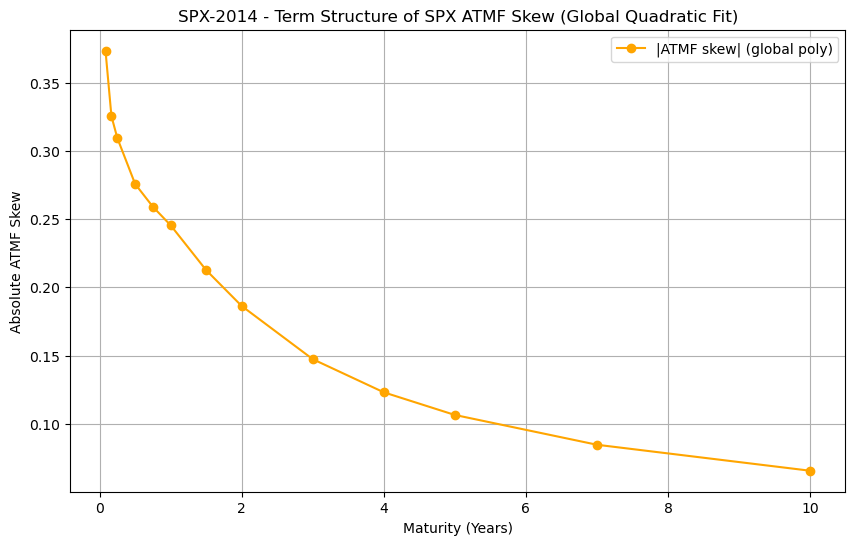

,maturity,T,forward,atmf_skew,abs_skew,index
0,1M,0.083333,1949.762170,-0.373284,0.373284,SPX-2014
1,2M,0.166667,1948.365341,-0.325393,0.325393,SPX-2014
2,3M,0.250000,1946.969512,-0.309285,0.309285,SPX-2014
3,6M,0.500000,1942.788025,-0.275732,0.275732,SPX-2014
4,9M,0.750000,1938.615517,-0.259009,0.259009,SPX-2014
5,1Y,1.000000,1934.451971,-0.245450,0.245450,SPX-2014
6,18M,1.500000,1926.151686,-0.212596,0.212596,SPX-2014
7,2Y,2.000000,1917.887016,-0.186329,0.186329,SPX-2014
8,3Y,3.000000,1901.463908,-0.147384,0.147384,SPX-2014
9,4Y,4.000000,1885.181434,-0.123108,0.123108,SPX-2014


In [20]:
# Compute global quadratic ATMF skew
spx2014_poly2_skew_df = compute_atmf_skew_global_quad(spx2014_df)

# Plot the result and display the DataFrame
plot_global_poly_skew(spx2014_poly2_skew_df)
spx2014_poly2_skew_df

## 2.4 Stochastic Volatility Inspired (SVI) Method:

In [20]:
from scipy.optimize import minimize

In [21]:
def compute_atmf_skew_ssvi(df):

    # 1) Compute forward price F, log-moneyness k, and total variance w
    df['F'] = df['spot'] * np.exp((df['r'] - df['q']) * df['T'])
    df['k'] = np.log(df['strike'] / df['F'])
    df['w'] = df['implied_vol']**2 * df['T']

    # 2) Extract ATM total variance θ(T) (point with |k| closest to 0 for each maturity)
    theta_by_T = (
        df
        .assign(abs_k = df['k'].abs()) # absolute log-moneyness
        .sort_values(['T','abs_k']) # sort each T-slice by closeness to ATM
        .groupby('T')['w']                    
        .first() # ATM total variance θ(T)
    )

    # 3) Calendar-spread check: θ(T) must be non-decreasing in T
    T_vals = theta_by_T.index.values
    θ_vals = theta_by_T.values
    if not np.all(np.diff(θ_vals) >= 0):
        raise ValueError("Calendar arbitrage: θ(T) not monotonic")

    # 4) Prepare arrays for SSVI calibration
    k_arr   = df['k'].values
    T_arr   = df['T'].values
    θ_arr   = df['T'].map(theta_by_T).values
    vol_arr = df['implied_vol'].values

    # 5) SSVI total variance w(k,θ) with φ(θ)=η θ^{-γ}
    def w_ssvi(k, θ, ρ, η, γ):
        φ = η * θ**(-γ)
        return θ/2 * (1 + ρ*φ*k + np.sqrt((φ*k + ρ)**2 + 1 - ρ**2))

    # 6) Calibration objective: minimize mean squared error in implied volatility
    def loss(x):
        ρ, η, γ = x
        w_pred   = w_ssvi(k_arr, θ_arr, ρ, η, γ)
        vol_pred = np.sqrt(w_pred / T_arr)
        return np.mean((vol_pred - vol_arr)**2)

    # 7) Build no-arbitrage constraints
    cons = []

    # (a) Butterfly constraints applied maturity-by-maturity
    for θ in θ_vals:
        cons.append({
            'type': 'ineq',
            'fun': lambda x, θ=θ: 4 - θ * (x[1] * θ**(-x[2])) * (1 + abs(x[0]))
        })
        cons.append({
            'type': 'ineq',
            'fun': lambda x, θ=θ: 4 - θ * (x[1] * θ**(-x[2]))**2 * (1 + abs(x[0]))
        })

    # (b) Calendar‐spread *upper* bound on ∂θ(θϕ):
    #     (1-γ) ≤ (1+√(1-ρ²)) / ρ²
    def shape_upper(x):
        ρ, η, γ = x
        # if ρ≈0 then RHS→∞, so constraint auto-satisfied
        if abs(ρ) < 1e-6:
            return 1e6
        rhs = (1 + np.sqrt(1 - ρ**2)) / (ρ**2)
        lhs = (1 - γ)
        return rhs - lhs

    cons.append({'type': 'ineq', 'fun': shape_upper})

    # 8) Parameter bounds and initial guess
    bnds = [(-0.99, 0.99), (1e-8, None), (1e-8, 0.999)]
    x0   = [0.2,       1.0,      0.5]    # start ρ=0.2 instead of 0

    # 9) Calibrate SSVI parameters (ρ,η,γ)
    res = minimize(
        loss,
        x0,
        method='SLSQP',
        bounds=bnds,
        constraints=cons,
        options={'ftol':1e-12, 'maxiter':500}
    )

    if not res.success:
        raise RuntimeError("SSVI calibration failed: " + res.message)

    rho, eta, gamma = res.x

    # 10) Compute ATMF skew: ∂σ/∂k at k=log(K/F)=0 for each maturity
    phi      = eta * θ_vals**(-gamma)
    skew     = rho * np.sqrt(θ_vals) * phi / (2 * np.sqrt(T_vals))
    abs_skew = np.abs(skew)

    # 11) Store results into a DataFrame
    results = pd.DataFrame({
        'T': T_vals,
        'skew': skew,
        'abs_skew': abs_skew,
        'index': df['index'].iloc[0],
    })

    return results.sort_values('T')

In [22]:
def plot_ssvi_skew(skew_df):
    plt.figure(figsize=(10, 6))
    plt.plot(skew_df['T'], skew_df['abs_skew'], 'o-', color='blue', label='|ATMF skew| (ssvi)')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Absolute ATMF Skew")
    plt.title(f"{skew_df['index'].iloc[0]} - Term Structure of SPX ATMF Skew (SSVI Method)")
    plt.grid(True)
    plt.legend()
    plt.show()

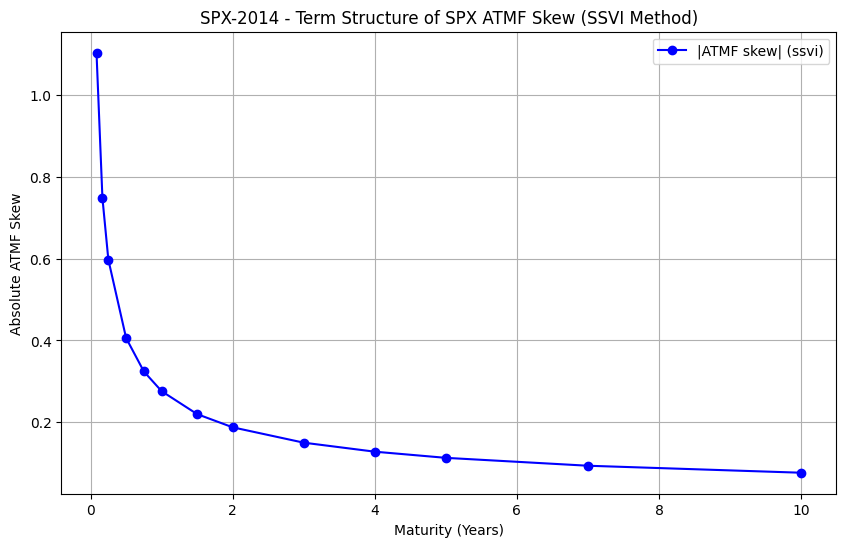

,T,skew,abs_skew,index
0,0.083333,-1.103755,1.103755,SPX-2014
1,0.166667,-0.748573,0.748573,SPX-2014
2,0.250000,-0.597719,0.597719,SPX-2014
3,0.500000,-0.405986,0.405986,SPX-2014
4,0.750000,-0.324160,0.324160,SPX-2014
5,1.000000,-0.276024,0.276024,SPX-2014
6,1.500000,-0.219860,0.219860,SPX-2014
7,2.000000,-0.187652,0.187652,SPX-2014
8,3.000000,-0.150085,0.150085,SPX-2014
9,4.000000,-0.128058,0.128058,SPX-2014


In [70]:
spx2014_ssvi_skew_df = compute_atmf_skew_ssvi(spx2014_df)
plot_ssvi_skew(spx2014_ssvi_skew_df)
spx2014_ssvi_skew_df

## 2.5 Stochastic Alpha Beta Rho (SABR) Method:

In [24]:
def compute_atmf_skew_sabr(df, beta=1.0):
    """
    For each maturity T, calibrate SABR parameters (alpha, rho, nu) to the market smile,
    then compute the ATMF skew ∂σ/∂k at k=log(K/F)=0 using a central finite difference
    of Hagan's SABR implied volatility formula.
    """

    def sabr_implied_vol(F, K, T, alpha, beta, rho, nu):
        # 1) Log-moneyness and SABR scaling term
        logFK = np.log(F / K)
        FK_beta = (F * K)**((1 - beta) / 2)

        # 2) Hagan's z and x(z)
        z = (nu / alpha) * FK_beta * logFK
        numerator = np.sqrt(1 - 2 * rho * z + z**2) + z - rho
        denom = 1 - rho
        x_z = np.log(numerator / denom)

        # 3) Prefactor and log-moneyness expansion terms
        prefactor = alpha / FK_beta
        term1 = 1 + (1 - beta)**2 / 24 * logFK**2 + (1 - beta)**4 / 1920 * logFK**4

        # 4) Time-dependent correction term
        corr = (
            (1 - beta)**2 / 24 * alpha**2 / (FK_beta**2)
            + 0.25 * rho * beta * nu * alpha / FK_beta
            + (2 - 3 * rho**2) / 24 * nu**2
        )
        term2 = 1 + corr * T

        # 5) z/x(z) ratio with ATM handling (avoid 0/0 near logFK=0)
        tol = 1e-8
        with np.errstate(invalid='ignore', divide='ignore'):
            ratio = np.where(
                np.abs(logFK) < tol,
                1.0,     # ATM limit
                z / x_z  # away from ATM
            )

        return prefactor * ratio * term1 * term2

    
    # 1) Compute forward price F and log-moneyness k
    df = df.copy()
    df['F'] = df['spot'] * np.exp((df['r'] - df['q']) * df['T'])
    df['k'] = np.log(df['strike'] / df['F'])

    results = []

    # 2) Calibrate SABR parameters maturity-by-maturity
    for T, slice_df in df.groupby('T', sort=True):
        F = slice_df['F'].iloc[0]
        K_arr = slice_df['strike'].values
        vol_arr = slice_df['implied_vol'].values

        # 2.1) Initial guess from ATM volatility
        atm_idx = np.argmin(np.abs(np.log(K_arr / F)))
        atm_vol = vol_arr[atm_idx]
        x0 = [0.0, 0.5, atm_vol * F**(1 - beta)]                 # [rho, nu, alpha]
        bnds = [(-0.99, 0.99), (1e-6, None), (1e-8, None)]

        # 2.2) Objective: minimize mean squared error in implied volatility
        def loss(params):
            rho_, nu_, alpha_ = params
            vols = sabr_implied_vol(F, K_arr, T, alpha_, beta, rho_, nu_)
            return np.mean((vols - vol_arr)**2)

        res = minimize(
            loss,
            x0,
            bounds=bnds,
            method='SLSQP',
            options={'ftol': 1e-12, 'maxiter': 500}
        )
        if not res.success:
            raise RuntimeError(f"SABR calibration failed (T={T}): {res.message}")

        rho_opt, nu_opt, alpha_opt = res.x

        # 3) Compute ATMF skew: ∂σ/∂k at k=log(K/F)=0 (central finite difference)
        h = 1e-5
        vol_up = sabr_implied_vol(F, F * np.exp(h),  T, alpha_opt, beta, rho_opt, nu_opt)
        vol_dn = sabr_implied_vol(F, F * np.exp(-h), T, alpha_opt, beta, rho_opt, nu_opt)
        skew = (vol_up - vol_dn) / (2 * h)

        results.append({
            'T': T,
            'skew': skew,
            'abs_skew': abs(skew),
            'index': slice_df['index'].iloc[0]
        })

    # 4) Return maturity-term structure of ATMF skew
    return pd.DataFrame(results).sort_values('T')


In [25]:
spx2014_sabr_skew_df = compute_atmf_skew_sabr(spx2014_df)
spx2014_sabr_skew_df

,T,skew,abs_skew,index
0,0.083333,-0.870873,0.870873,SPX-2014
1,0.166667,-0.594989,0.594989,SPX-2014
2,0.250000,-0.495044,0.495044,SPX-2014
3,0.500000,-0.367567,0.367567,SPX-2014
4,0.750000,-0.314158,0.314158,SPX-2014
5,1.000000,-0.279206,0.279206,SPX-2014
6,1.500000,-0.227158,0.227158,SPX-2014
7,2.000000,-0.195000,0.195000,SPX-2014
8,3.000000,-0.151430,0.151430,SPX-2014
9,4.000000,-0.125498,0.125498,SPX-2014


## 2.6 Plot all skew estimations on the same graph:

In [26]:
def plot_all_skews(spline_df, poly_df, ssvi_df, sabr_df):
    """
    spline_df : DataFrame for spline‐based skew (must have 'T' and 'abs_skew')
    poly_df   : DataFrame for quad‐poly skew
    ssvi_df   : DataFrame for SSVI skew
    sabr_df   : DataFrame for SABR skew
    """
    
    plt.figure(figsize=(10, 6))
    
    # 1) Spline in red
    plt.plot(
        spline_df['T'],
        spline_df['abs_skew'],
        'o-',
        color='r',
        label='|ATMF skew| (spline)'
    )

    # 2) Quadratic polynomial in orange
    plt.plot(
        poly_df['T'],
        poly_df['abs_skew'],
        'o-',
        color='orange',
        label='|ATMF skew| (quad poly)'
    )

    # 3) SSVI in blue
    plt.plot(
        ssvi_df['T'],
        ssvi_df['abs_skew'],
        'o-',
        color='b',
        label='|ATMF skew| (SSVI)'
    )

    # 4) SABR in black
    plt.plot(
        sabr_df['T'],
        sabr_df['abs_skew'],
        'o-',
        color='black',
        label='|ATMF skew| (SABR)'
    )

    plt.xlabel("Maturity (Years)")
    plt.ylabel("Absolute ATMF Skew")
    plt.title(f"{spline_df['index'].iloc[0]} – Comparison of ATMF Skew Methods")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

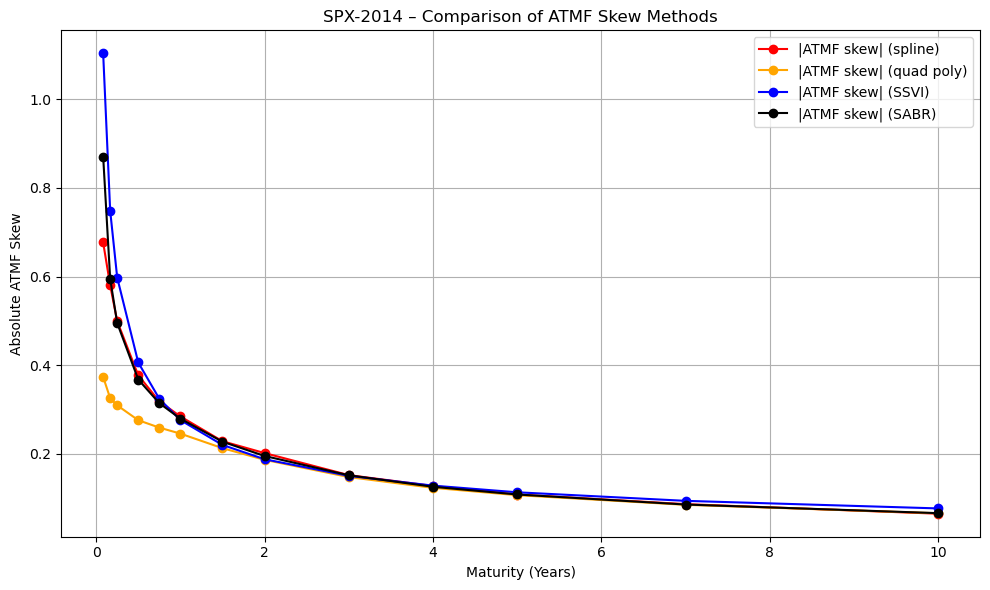

In [31]:
plot_all_skews(spx2014_spline_skew_df, spx2014_poly2_skew_df, spx2014_ssvi_skew_df, spx2014_sabr_skew_df)

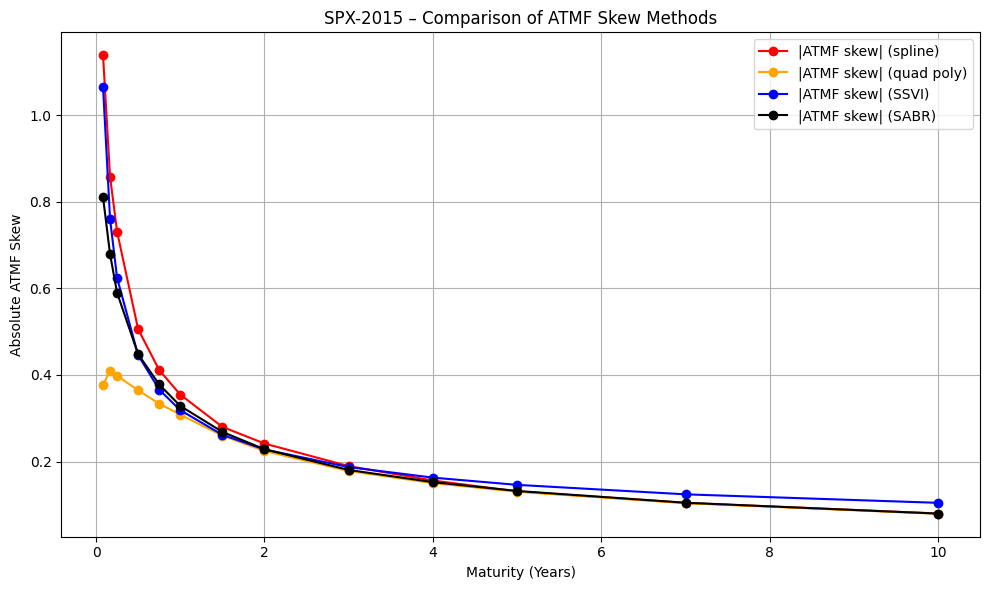

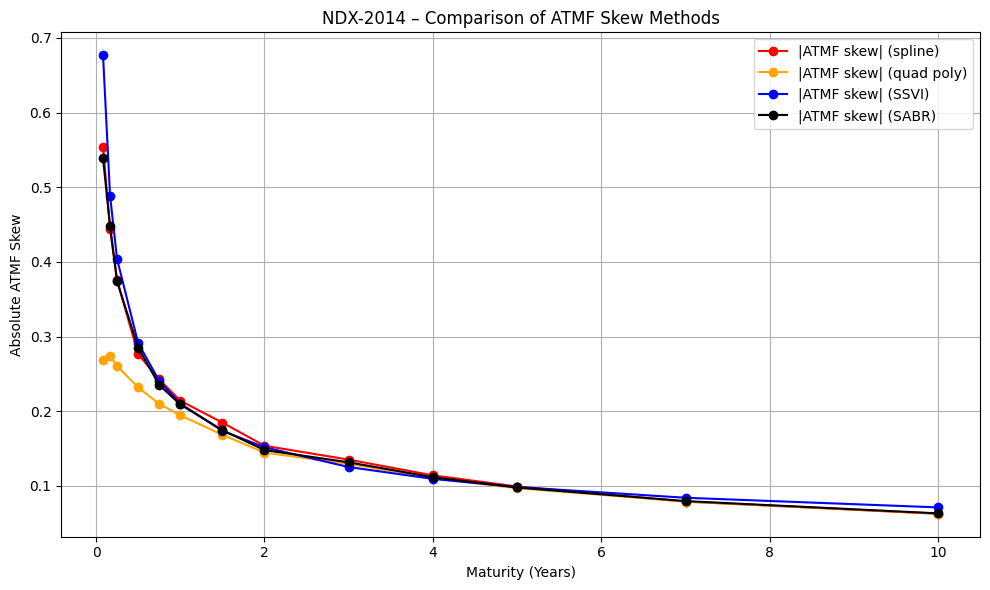

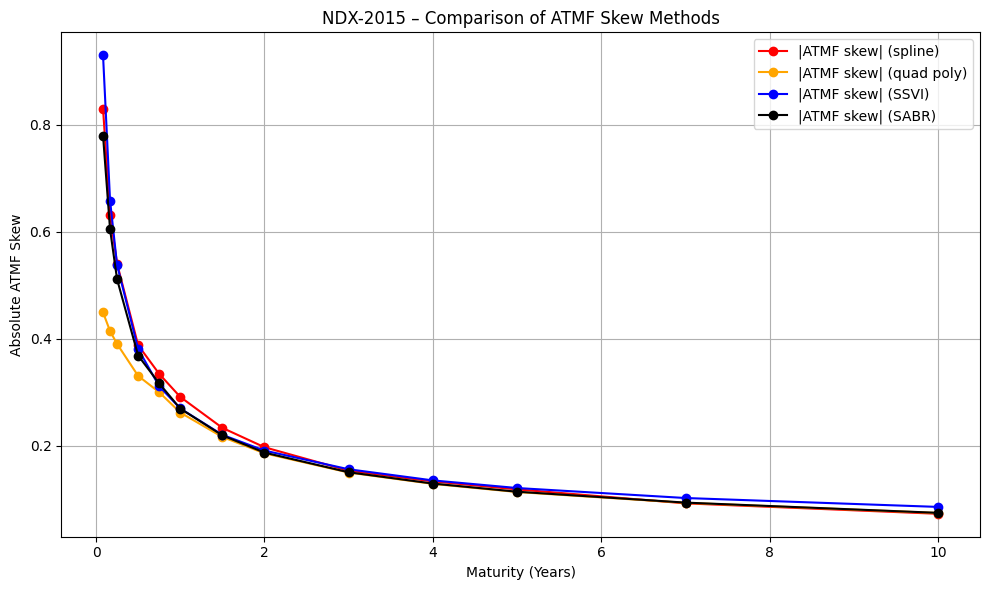

In [27]:
# SPX-2015
spx2015_spline_skew_df = compute_atmf_skew_spline(spx2015_df)
spx2015_poly2_skew_df = compute_atmf_skew_global_quad(spx2015_df)
spx2015_ssvi_skew_df = compute_atmf_skew_ssvi(spx2015_df)
spx2015_sabr_skew_df = compute_atmf_skew_sabr(spx2015_df)

# NDX-2014
ndx2014_spline_skew_df = compute_atmf_skew_spline(ndx2014_df)
ndx2014_poly2_skew_df = compute_atmf_skew_global_quad(ndx2014_df)
ndx2014_ssvi_skew_df = compute_atmf_skew_ssvi(ndx2014_df)
ndx2014_sabr_skew_df = compute_atmf_skew_sabr(ndx2014_df)

# NDX-2015
ndx2015_spline_skew_df = compute_atmf_skew_spline(ndx2015_df)
ndx2015_poly2_skew_df = compute_atmf_skew_global_quad(ndx2015_df)
ndx2015_ssvi_skew_df = compute_atmf_skew_ssvi(ndx2015_df)
ndx2015_sabr_skew_df = compute_atmf_skew_sabr(ndx2015_df)

# Plots
plot_all_skews(spx2015_spline_skew_df, spx2015_poly2_skew_df, spx2015_ssvi_skew_df, spx2015_sabr_skew_df)
plot_all_skews(ndx2014_spline_skew_df, ndx2014_poly2_skew_df, ndx2014_ssvi_skew_df, ndx2014_sabr_skew_df)
plot_all_skews(ndx2015_spline_skew_df, ndx2015_poly2_skew_df, ndx2015_ssvi_skew_df, ndx2015_sabr_skew_df)

Based on the results from STEP 2, I will compute a proxy for the true skew by taking the arithmetic average of the measures obtained from the three most robust methods (spline, SVI, and SABR), excluding the polynomial one (shown in yellow).

# <u>STEP 3</u>: Distributional & Time Series Analysis.

This step analyzes a large time-series dataset of implied volatility surfaces. The term structure of the skew proxy is computed on a daily basis and a power-law specification is fitted to characterize its structural behavior. The step then examines the main distributional properties and time-series characteristics of the resulting skew series, which will be useful for the next modeling step.

## 3.1 Data Extraction & Cleaning:

In [28]:
import re

In [29]:
def load_dataset(path: str, sheet_name=0) -> pd.DataFrame:
    """
    Universal loader for SPX/SX5E‐style implied‐vol Excel sheets.
    Returns:
      date, maturity, T, strike, moneyness, implied_vol, spot, r, q, index
    where `index` is the ticker prefix (e.g. "SPX" or "SX5E").
    """
    
    # 1) Read in the raw Excel
    df = pd.read_excel(path, sheet_name=sheet_name, header=0)

    # 2) Auto‐detect the prefix via the 100% strike column
    pfx_re = re.compile(r"^(?P<pfx>.+?)\s+100% MONEYNESS - U/LYING PRICE$")
    prefixes = { m.group("pfx") for col in df.columns if (m := pfx_re.match(col)) }
    if len(prefixes) != 1:
        raise ValueError(f"Expected one prefix, found: {prefixes}")
    prefix = prefixes.pop()

    # 3) That prefix *is* our index value
    idx_label = prefix

    # 4) Pull off the 100%‐moneyness underlying price as `spot`
    df["spot"] = df[f"{prefix} 100% MONEYNESS - U/LYING PRICE"]

    # 5) Fixed moneyness grid
    m_vals   = [0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20]
    pct_list = [int(m*100) for m in m_vals]

    # 6) Discover all the tenor‐suffixes dynamically
    iv_re     = re.compile(
        rf"^{re.escape(prefix)}\s+\d+% MONEYNESS - IMPLIED VOL (?P<suf>.+)$"
    )
    suffixes  = { m.group("suf") for col in df.columns if (m := iv_re.match(col)) }

    # 7) Parse suffix → (raw_suffix, T, mat_code)
    tenor_specs = []
    for suf in suffixes:
        norm  = suf.strip().rstrip(".")
        parts = norm.split()
        if len(parts)!=2: 
            continue
        num, unit = parts
        try:
            num = int(num)
        except ValueError:
            continue

        if unit.upper().startswith("MTH"):
            T    = num/12
            code = f"{num}M"
        else:
            T    = float(num)
            code = f"{num}Y"

        tenor_specs.append((suf, T, code))

    tenor_specs.sort(key=lambda x: x[1])  # by T ascending

    # 8) Build long‐form records
    records = []
    for _, row in df.iterrows():
        date = row["Dates"]
        s0   = row["spot"]

        for suf, Tval, mat in tenor_specs:
            for pct, m in zip(pct_list, m_vals):
                strike_col = f"{prefix} {pct}% MONEYNESS - U/LYING PRICE"
                iv_col     = f"{prefix} {pct}% MONEYNESS - IMPLIED VOL {suf}"
                if strike_col in row and iv_col in row:
                    records.append({
                        "date":        date,
                        "maturity":    mat,
                        "T":           Tval,
                        "strike":      row[strike_col],
                        "moneyness":   m,
                        "implied_vol": row[iv_col] / 100.0,
                        "spot":        s0,
                        "r":           0.0,
                        "q":           0.0,
                        "index":      idx_label,
                    })

    # 9) Assemble and sort
    out = pd.DataFrame.from_records(records,
        columns=["date","maturity","T",
                 "strike","moneyness","implied_vol",
                 "spot","r","q","index"]
    )

    return out.sort_values(["date","T","moneyness"], ignore_index=True)


In [30]:
df_spx = load_dataset("data/dataset_spx.xlsx")

In [33]:
df_sx5e = load_dataset("data/dataset_sx5e.xlsx")

In [34]:
df_spx

,date,maturity,T,strike,moneyness,implied_vol,spot,r,q,index
0,2011-10-03,1M,0.083333,879.3838,0.80,0.5678,1099.23,0.0,0.0,SPX
1,2011-10-03,1M,0.083333,934.3452,0.85,0.5289,1099.23,0.0,0.0,SPX
2,2011-10-03,1M,0.083333,989.3069,0.90,0.4691,1099.23,0.0,0.0,SPX
3,2011-10-03,1M,0.083333,1044.2680,0.95,0.4216,1099.23,0.0,0.0,SPX
4,2011-10-03,1M,0.083333,1099.2300,1.00,0.3971,1099.23,0.0,0.0,SPX
...,...,...,...,...,...,...,...,...,...,...
154499,2022-04-28,2Y,2.000000,4073.1250,0.95,0.2426,4287.50,0.0,0.0,SPX
154500,2022-04-28,2Y,2.000000,4287.5000,1.00,0.2312,4287.50,0.0,0.0,SPX
154501,2022-04-28,2Y,2.000000,4501.8710,1.05,0.2202,4287.50,0.0,0.0,SPX
154502,2022-04-28,2Y,2.000000,4716.2460,1.10,0.2096,4287.50,0.0,0.0,SPX


In [35]:
df_sx5e

,date,maturity,T,strike,moneyness,implied_vol,spot,r,q,index
0,2007-04-27,1M,0.083333,3506.503,0.80,0.3399,4383.129,0.0,0.0,SX5E
1,2007-04-27,1M,0.083333,3725.659,0.85,0.2955,4383.129,0.0,0.0,SX5E
2,2007-04-27,1M,0.083333,3944.816,0.90,0.2535,4383.129,0.0,0.0,SX5E
3,2007-04-27,1M,0.083333,4163.969,0.95,0.2195,4383.129,0.0,0.0,SX5E
4,2007-04-27,1M,0.083333,4383.129,1.00,0.2010,4383.129,0.0,0.0,SX5E
...,...,...,...,...,...,...,...,...,...,...
313195,2022-04-28,5Y,5.000000,3588.171,0.95,0.2168,3777.022,0.0,0.0,SX5E
313196,2022-04-28,5Y,5.000000,3777.022,1.00,0.2092,3777.022,0.0,0.0,SX5E
313197,2022-04-28,5Y,5.000000,3965.870,1.05,0.2032,3777.022,0.0,0.0,SX5E
313198,2022-04-28,5Y,5.000000,4154.719,1.10,0.1971,3777.022,0.0,0.0,SX5E


## 3.2 Compute Proxy and fit Power Law (for specific dates):

In [36]:
def compute_proxy(df, date, index='SPX'):
    
    # 1) filter
    sub = df[(df['date'] == date) & (df['index'] == index)].copy()
    if sub.empty:
        raise ValueError(f"No data for date={date}, index={index}")
    
    # 2) build each term‐structure
    df_sp = compute_atmf_skew_spline(sub)[['T','atmf_skew']].rename(columns={'atmf_skew':'spline'})
    df_sv = compute_atmf_skew_ssvi (sub)[['T','skew']     ].rename(columns={'skew'      :'svi'})
    df_sb = compute_atmf_skew_sabr (sub)[['T','skew']].rename(columns={'skew':'sabr'})
    
    # 3) merge on T
    df_ts = df_sp.merge(df_sv, on='T').merge(df_sb, on='T')
    
    # 4) proxy = simple average
    df_ts['proxy'] = df_ts[['spline','svi','sabr']].mean(axis=1)

    return df_ts.sort_values('T')

def fit_powerlaw_by_minimize(T, proxy):
    """
    Fit proxy ≈ A * T^{-alpha} by minimizing Σ[A T^{-α} − proxy]^2.
    """
    def loss(x):
        A, alpha = x
        return np.sum((A * T**(-alpha) - proxy)**2)

    x0   = [np.mean(proxy), 0.5]           # initial A, alpha
    bnds = [(None, None), (0.0, None)]      # A free, alpha ≥ 0
    res  = minimize(loss, x0, bounds=bnds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Power‐law fit failed: " + res.message)
    return res.x  # A_opt, alpha_opt

def compute_proxy_and_powerlaw(df, date, index='SPX'):
    # 1) get the spline/svi/sabr term‐structures + average proxy
    df_ts = compute_proxy(df, date, index)   # must return cols ['T','spline','svi','sabr','proxy']
    
    # 2) take absolute value of the proxy (new!)
    df_ts['proxy'] = df_ts['proxy'].abs()
    
    # 3) fit A, α via least‐squares minimize
    T_vals  = df_ts['T'].values
    proxy_v = df_ts['proxy'].values
    A_opt, alpha_opt = fit_powerlaw_by_minimize(T_vals, proxy_v)

    # 4) compute fitted curve
    df_ts = df_ts.copy()
    df_ts['fitted'] = A_opt * df_ts['T']**(-alpha_opt)

    return df_ts.sort_values('T'), {'A': A_opt, 'alpha': alpha_opt}

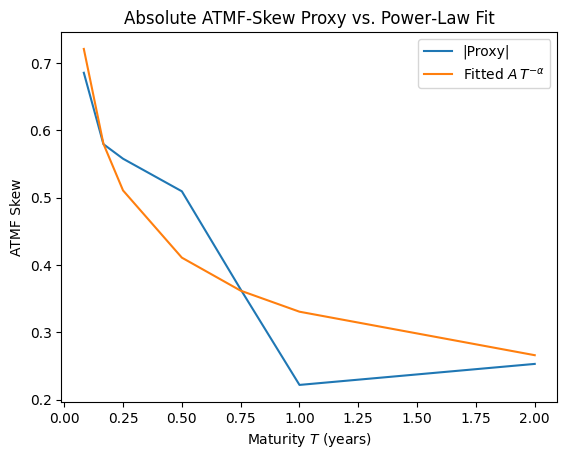

{'A': np.float64(0.33047833876345484), 'alpha': np.float64(0.3138451838619853)}


,T,spline,svi,sabr,proxy,fitted
0,0.083333,-0.4996842881325014,-0.806162,-0.750434,0.685427,0.720840
1,0.166667,-0.45667537053823093,-0.635379,-0.646042,0.579365,0.579912
2,0.250000,-0.5587810979900626,-0.567139,-0.547305,0.557742,0.510619
3,0.500000,-0.6069867038952966,-0.453915,-0.467124,0.509342,0.410790
4,0.750000,-0.35412895163669295,-0.392204,-0.344453,0.363596,0.361705
5,1.000000,0.01497870887330116,-0.353080,-0.327037,0.221713,0.330478
6,2.000000,-0.20551540760612064,-0.279582,-0.273677,0.252925,0.265868


In [ ]:
# 1) compute the term‐structure for your chosen date
df_term, params = compute_proxy_and_powerlaw(df_spx, '2011-10-03')

# 2) make the plot
plt.plot(df_term['T'], df_term['proxy'],    label='|Proxy|')
plt.plot(df_term['T'], df_term['fitted'],  label=r'Fitted $A\,T^{-\alpha}$')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('ATMF Skew')
plt.title('Absolute ATMF‐Skew Proxy vs. Power‐Law Fit')
plt.legend()
plt.show()

# 3) print results
print(params)
display(df_term)

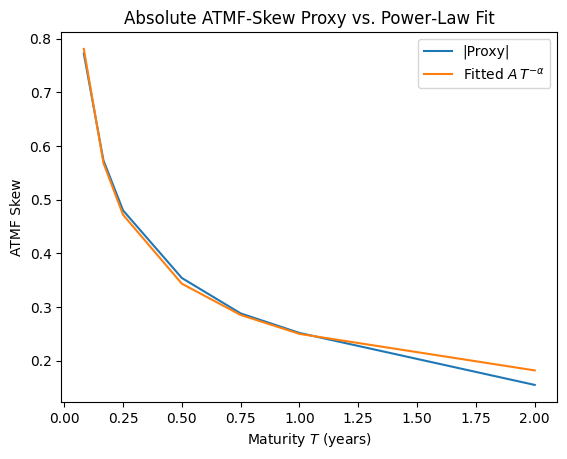

{'A': np.float64(0.24998790642066607), 'alpha': np.float64(0.45831799082578006)}


,T,spline,svi,sabr,proxy,fitted
0,0.083333,-0.44913896622600935,-1.219005,-0.648555,0.772233,0.780777
1,0.166667,-0.5006523028566827,-0.722059,-0.497022,0.573245,0.568277
2,0.250000,-0.4724750209669638,-0.531729,-0.436030,0.480078,0.471904
3,0.500000,-0.3884912559654119,-0.313650,-0.360128,0.35409,0.343468
4,0.750000,-0.3199137452627536,-0.231497,-0.312935,0.288115,0.285220
5,1.000000,-0.2828230898256078,-0.186923,-0.285458,0.251735,0.249988
6,2.000000,-0.16267730139981793,-0.112081,-0.189998,0.154919,0.181950


In [ ]:
# 1) compute the term‐structure for your chosen date
df_term, params = compute_proxy_and_powerlaw(df_spx, '2014-06-09')

# 2) make the plot
plt.plot(df_term['T'], df_term['proxy'],    label='|Proxy|')
plt.plot(df_term['T'], df_term['fitted'],  label=r'Fitted $A\,T^{-\alpha}$')
plt.xlabel('Maturity $T$ (years)')
plt.ylabel('ATMF Skew')
plt.title('Absolute ATMF‐Skew Proxy vs. Power‐Law Fit')
plt.legend()
plt.show()

# 3) print results
print(params)
display(df_term)

## 3.3 Compute Proxy and fit Power Law (for all the Time Series):

In [40]:
from joblib import Parallel, delayed

In [41]:
def make_term_structure_ts(df, date_col='date', n_jobs=-1):
    # ensure your date column is datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # build (date, slice) pairs only once
    groups = list(df.groupby(date_col))

    def _process_date(date_grp):
        date, df_date = date_grp
        try:
            df_term, _ = compute_proxy_and_powerlaw(df_date, date)
            return df_term[['T','fitted']].assign(**{date_col: date})
        except Exception:
            return None

    # run in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(_process_date)(dg) for dg in groups
    )

    # stitch together
    df_all = pd.concat(r for r in results if r is not None)
    return (
        df_all
          .pivot(index=date_col, columns='T', values='fitted')
          .sort_index()
    )

In [42]:
df_spx_ts  = make_term_structure_ts(df_spx)

In [43]:
df_spx_ts

T,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000
date,,,,,,,
2011-10-03,0.720840,0.579912,0.510619,0.410790,0.361705,0.330478,0.265868
2011-10-04,1.262423,1.033008,0.918656,0.751712,0.668499,0.615107,0.503326
2011-10-05,0.960795,0.802063,0.721663,0.602438,0.542049,0.502910,0.419825
2011-10-06,0.863357,0.722066,0.650393,0.543954,0.489961,0.454934,0.380483
2011-10-07,0.696833,0.560514,0.493495,0.396954,0.349491,0.319299,0.256835
...,...,...,...,...,...,...,...
2022-04-22,1.038479,0.776812,0.655485,0.490321,0.413740,0.366774,0.274357
2022-04-25,0.964567,0.745711,0.641496,0.495944,0.426634,0.383416,0.296421
2022-04-26,1.720748,1.038838,0.773289,0.466845,0.347509,0.281840,0.170151


## 3.4 Plot the Time Series:

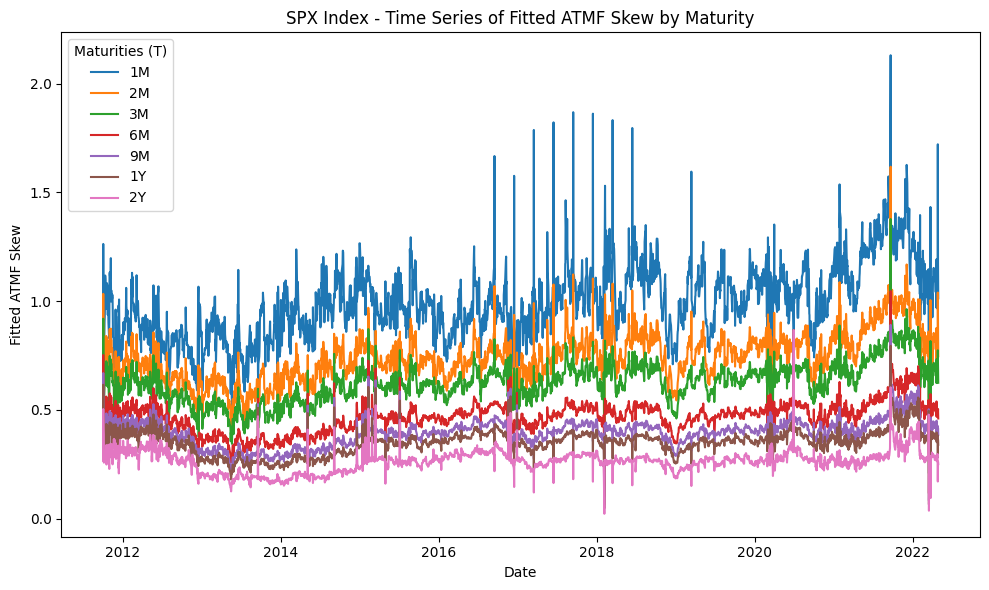

In [44]:
def maturity_label(T):
    
    # if it’s already been renamed, just pass it through
    if isinstance(T, str):
        return T

    # otherwise convert years → months and format
    months = int(round(T * 12))
    if months % 12 == 0:
        return f"{months // 12}Y"
    else:
        return f"{months}M"

df_spx_ts.rename(columns=lambda T: maturity_label(T), inplace=True)

plt.figure(figsize=(10,6))
for col in df_spx_ts.columns:
    plt.plot(df_spx_ts.index, df_spx_ts[col], label=col)

plt.xlabel("Date")
plt.ylabel("Fitted ATMF Skew")
plt.title("SPX Index - Time Series of Fitted ATMF Skew by Maturity")
plt.legend(title="Maturities (T)")
plt.tight_layout()
plt.show()

## 3.5 Study of main distributional features:

In [45]:
# long-run mean, std, min/max, quartiles, skewness & kurtosis
desc = df_spx_ts.describe().T
desc['skew']    = df_spx_ts.skew()
desc['kurtosis']= df_spx_ts.kurtosis()
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
T,,,,,,,,,,
1M,2756.0,0.992728,0.169065,0.512313,0.879959,0.978317,1.095445,2.130190,0.716322,1.978048
2M,2756.0,0.739849,0.110614,0.292584,0.668477,0.733687,0.806078,1.617685,0.459260,1.749769
3M,2756.0,0.623628,0.089822,0.207782,0.567916,0.623528,0.675848,1.377136,0.355730,2.289676
6M,2756.0,0.466500,0.068791,0.099817,0.428796,0.470777,0.505587,1.045809,0.296153,3.238476
9M,2756.0,0.394068,0.061736,0.063830,0.361781,0.400328,0.428514,0.890298,0.374933,3.918285
1Y,2756.0,0.349773,0.058064,0.046478,0.319156,0.355080,0.380726,0.866180,0.490546,4.733380
2Y,2756.0,0.262864,0.051633,0.021641,0.236129,0.266342,0.288168,0.866180,0.951936,8.785906


The table above confirms what is observed in the preceding time-series plot: the shorter the maturity, the more important the long-term mean and the dispersion of the skew.

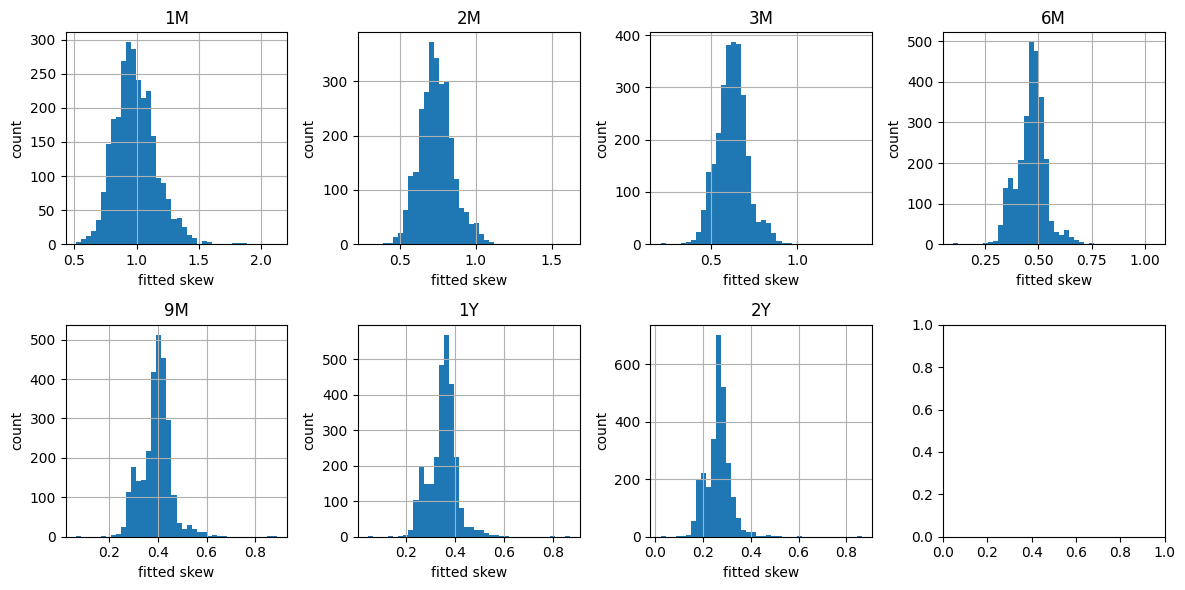

In [46]:
# multiples grid of histograms

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, col in zip(axes, df_spx_ts.columns):
    df_spx_ts[col].hist(bins=40, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("fitted skew")
    ax.set_ylabel("count")

plt.tight_layout()
plt.show()

## 3.6 Study of the Time Series characteristics:

In [49]:
# L-jung Box test for serial correlation
    # H0: the time series is white noise
    # H1: the time series is not white noise

from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(df_spx_ts['2M'], lags=[10, 20, 50, 100, 200, 500, 1000, 2500], return_df=True)
print(lb)

            lb_stat  lb_pvalue
10     16361.279420        0.0
20     28853.439978        0.0
50     56415.153588        0.0
100    88130.563402        0.0
200   122442.302806        0.0
500   148912.496423        0.0
1000  159296.157000        0.0
2500  462192.969519        0.0


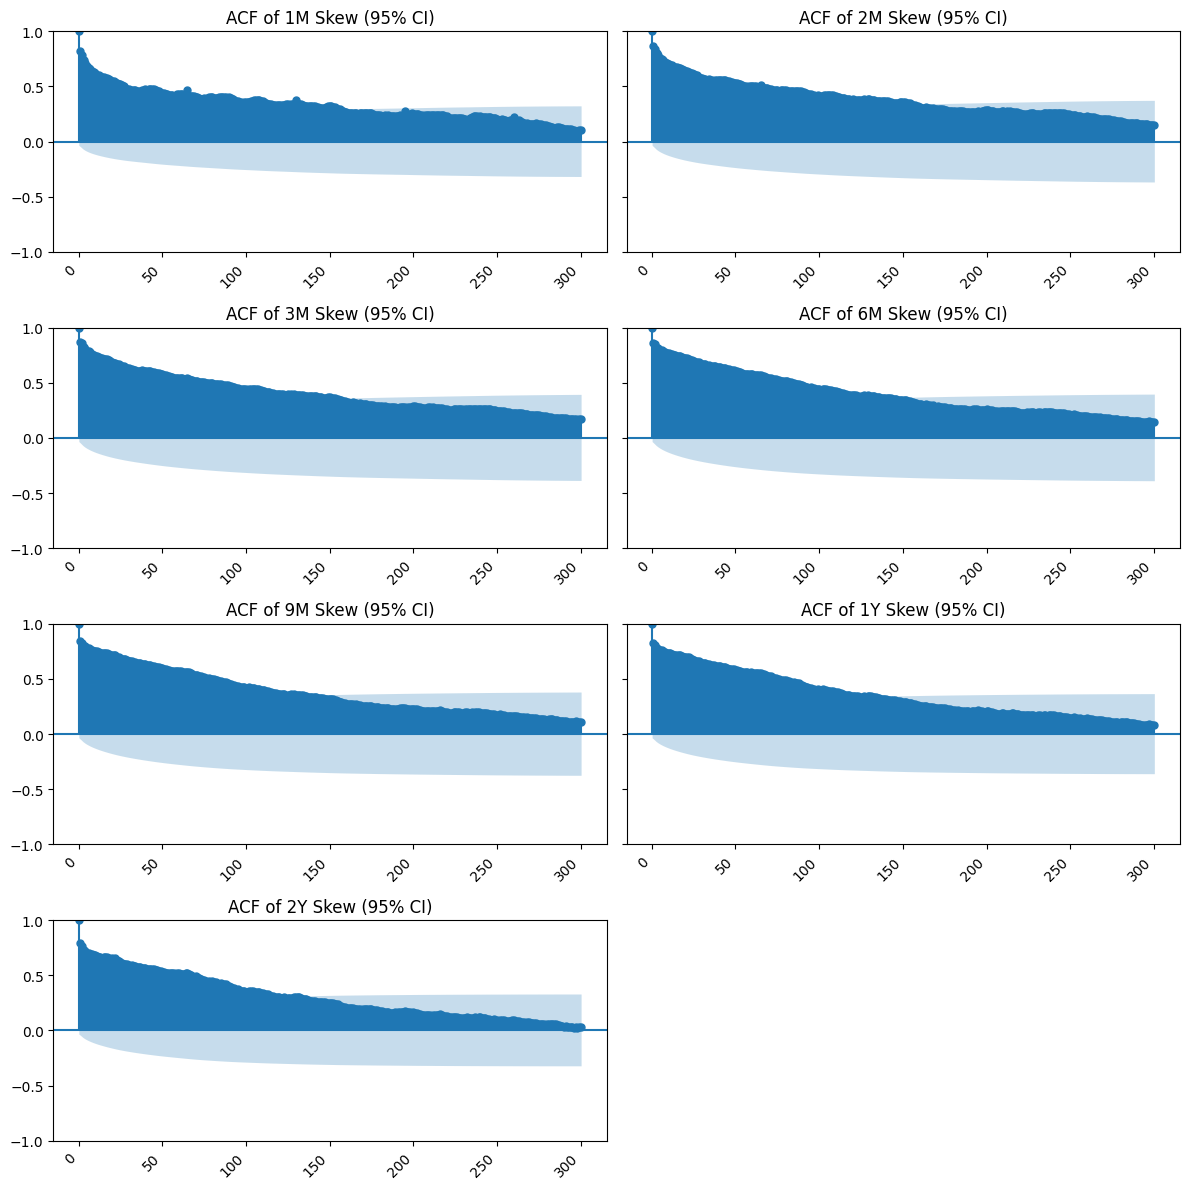

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

# Get all maturities (columns) from df_spx_ts
maturities = df_spx_ts.columns
n_maturities = len(maturities)

# Calculate the number of rows needed (2 plots per row)
n_cols = 2
n_rows = (n_maturities + 1) // 2  # Ceiling division to ensure enough rows

# Create a figure with subplots (n_rows x 2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), sharey=True)

# Flatten axes array for easier iteration (in case of multiple rows)
axes = axes.flatten()

# Plot ACF for each maturity
for idx, maturity in enumerate(maturities):
    ax = axes[idx]
    plot_acf(
        df_spx_ts[maturity].dropna(),
        lags=300,
        alpha=0.05,  # 95% confidence
        use_vlines=True,
        ax=ax
    )
    ax.set_title(f"ACF of {maturity} Skew (95% CI)")
    ax.set_xlabel("")  # Add x-axis label to indicate units
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate labels for readability

# Turn off any unused subplots
for idx in range(n_maturities, len(axes)):
    axes[idx].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('acf_plots_all_maturities.png', bbox_inches="tight", dpi=300)

According to the ACF Plots, there might be strong and persistent autocorrelation, up to around lag 150...

In [51]:
from statsmodels.tsa.stattools import acf
from scipy.stats import norm

def acf_with_pvalues(series, nlags=40, alpha=0.05):
    # Drop any NaNs
    x = series.dropna().values
    n = len(x)
    
    # 1) Get acf and confidence intervals
    acfs, confint = acf(x, nlags=nlags, alpha=alpha, fft=False)
    
    # 2) Approximate standard error under H0: rho_k=0
    se = 1/np.sqrt(n)
    
    # 3) Compute two-sided p-values for each lag
    zs = acfs / se
    pvals = 2*(1 - norm.cdf(np.abs(zs)))
    
    # 4) Determine significance: if confint at lag k does not include zero
    signif = (confint[:,0] > 0) | (confint[:,1] < 0)
    
    return pd.DataFrame({
        'lag':        np.arange(len(acfs)),
        'acf':        acfs,
        'lower_ci':   confint[:,0],
        'upper_ci':   confint[:,1],
        'p_value':    pvals,
        'significant': signif
    }).set_index('lag')

# Compute ACF with p-values for all maturities
maturities = df_spx_ts.columns
last_significant_lags = {}

for maturity in maturities:
    # Compute ACF table for the current maturity
    acf_table = acf_with_pvalues(df_spx_ts[maturity], nlags=200)
    
    # Find the highest lag that remains significant at 5%
    sig_lags = acf_table.index[acf_table['significant']]
    last_significant_lags[maturity] = sig_lags.max() if len(sig_lags) > 0 else 0

# Print only the last significant lag for each maturity
print("\nLast significant lag for each maturity:")
for maturity, lag in last_significant_lags.items():
    print(f"{maturity}: {lag}")


Last significant lag for each maturity:
1M: 156
2M: 156
3M: 154
6M: 142
9M: 134
1Y: 132
2Y: 120


... which is confirmed here. This implies that past values of the skew help predict future values.

Moreover, the plot of the 3-month rolling window of the 2M skew Time Serie suggests mean-reverting behavior...

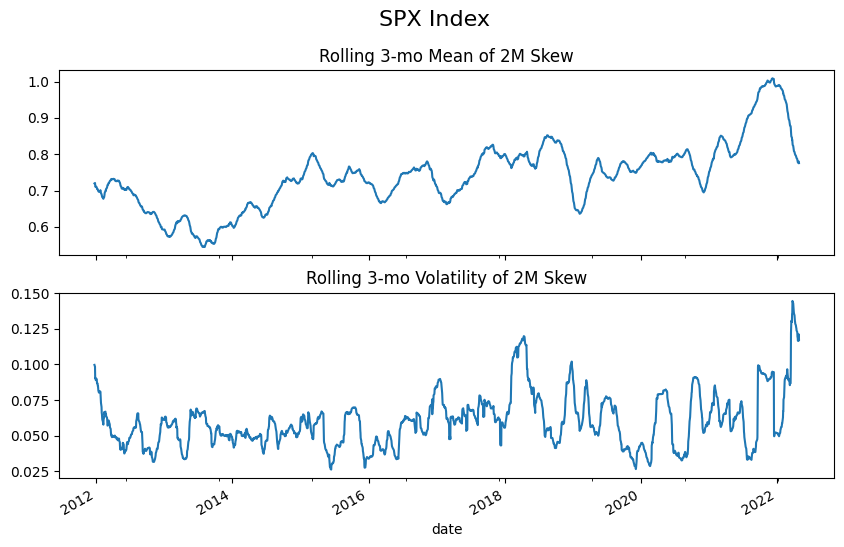

In [52]:
rolling = df_spx_ts.rolling(window=60)  # 60 trading days ~ 3mo
roll_mean = rolling.mean()
roll_std  = rolling.std()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# individual subplot titles
roll_mean['2M'].plot(ax=ax[0], title="Rolling 3-mo Mean of 2M Skew")
roll_std ['2M'].plot(ax=ax[1], title="Rolling 3-mo Volatility of 2M Skew")

# super‐title for the whole figure
fig.suptitle("SPX Index", fontsize=16)

plt.show()

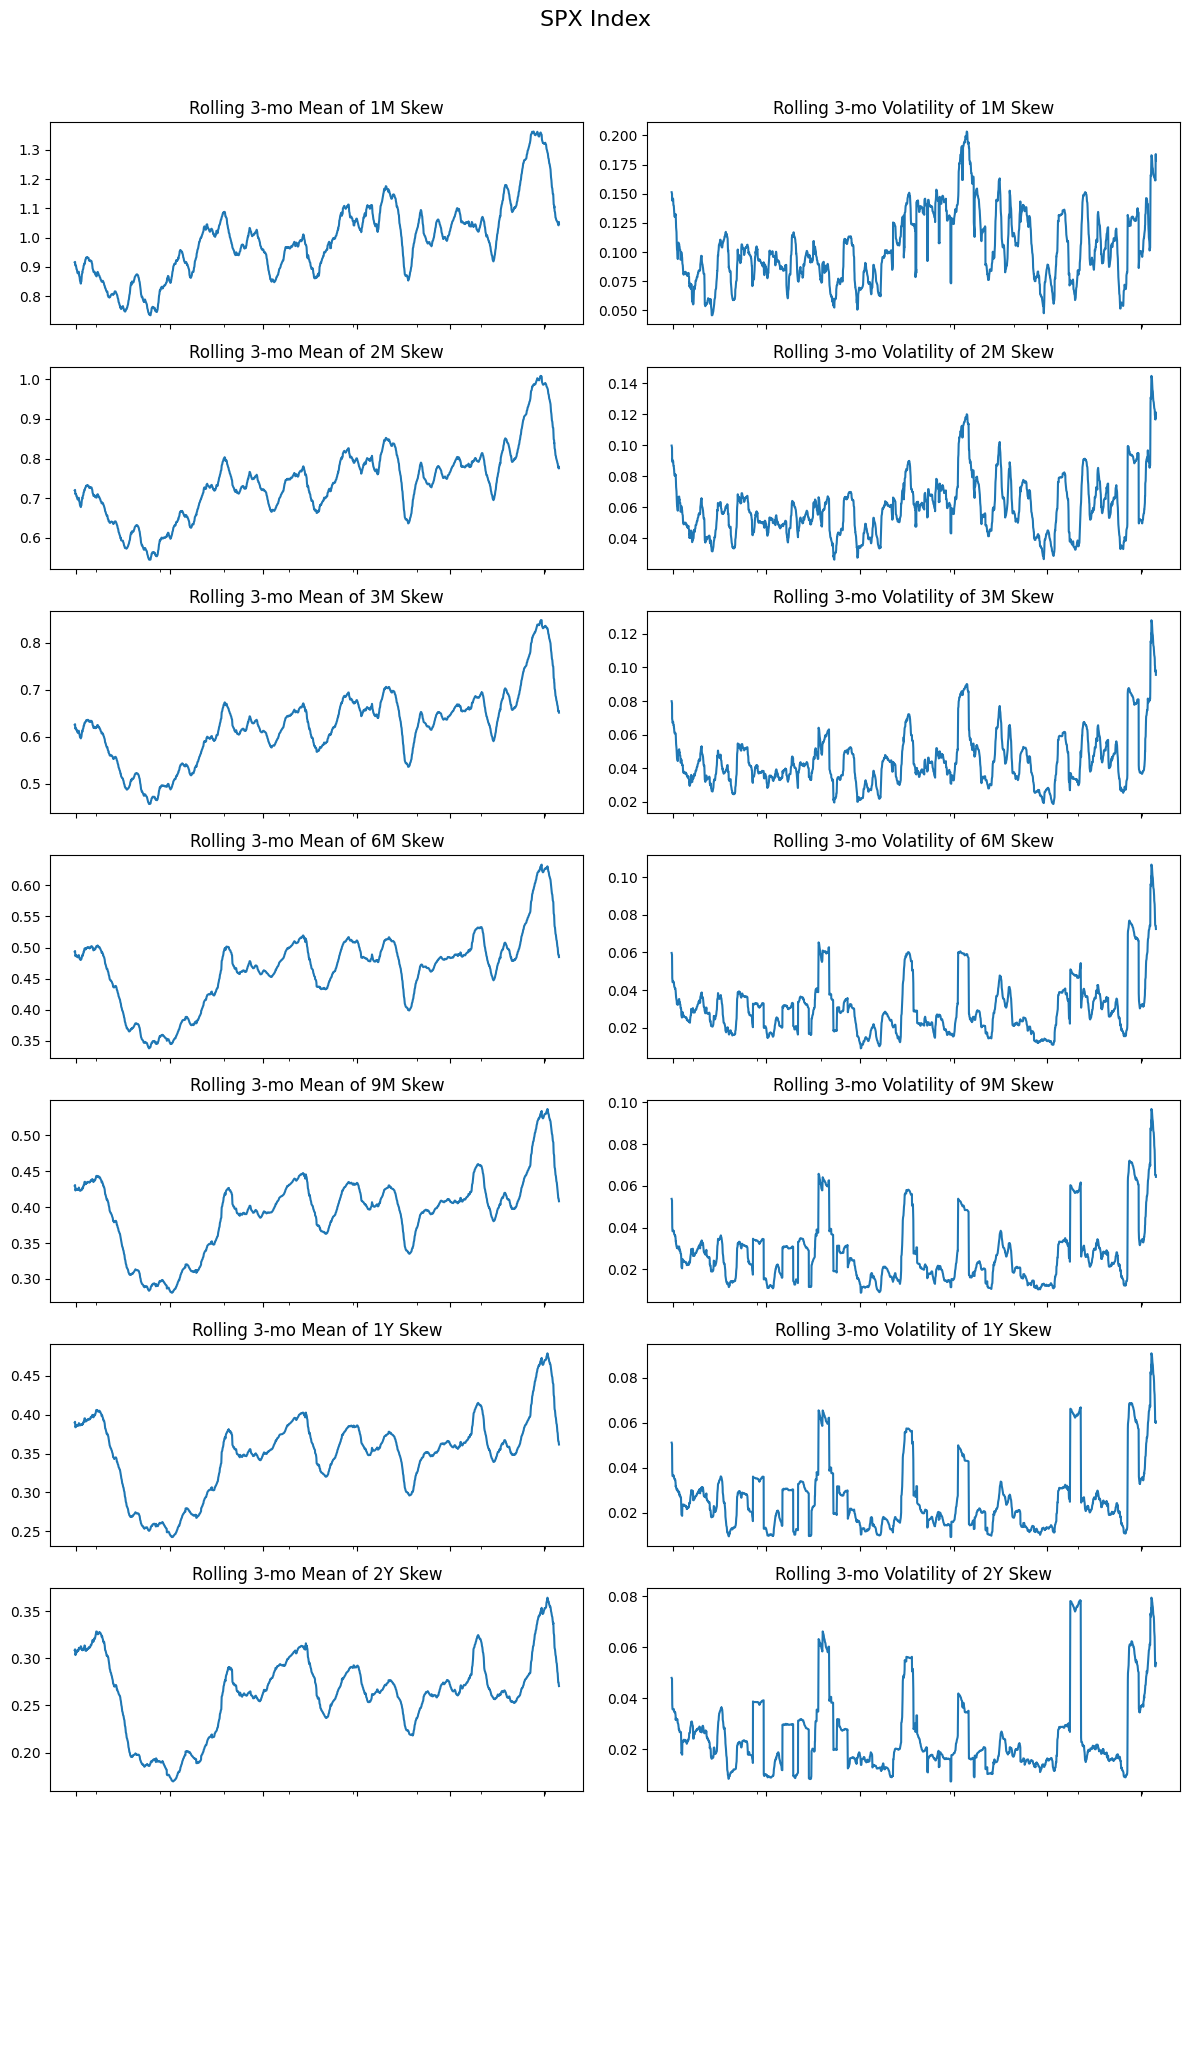

In [53]:
import matplotlib.dates as mdates

# Compute rolling statistics for all maturities
rolling = df_spx_ts.rolling(window=60)  # 60 trading days ~ 3mo
roll_mean = rolling.mean()
roll_std = rolling.std()

# Get all maturities (columns) from df_spx_ts
maturities = df_spx_ts.columns
n_maturities = len(maturities)

# Calculate the number of rows needed (2 plots per row, each maturity needs 2 subplots)
n_cols = 2
n_plots = n_maturities * 2  # Each maturity has mean and std plots
n_rows = (n_maturities + 1) // 2 * 2  # Ceiling division, then multiply by 2 for mean and std

# Create a figure with subplots (n_rows x 2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), sharex=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot rolling mean and std for each maturity
for idx, maturity in enumerate(maturities):
    # Index for mean plot (top)
    mean_idx = idx * 2
    # Index for std plot (bottom)
    std_idx = mean_idx + 1

    # Plot rolling mean
    roll_mean[maturity].plot(ax=axes[mean_idx])
    axes[mean_idx].set_title(f"Rolling 3-mo Mean of {maturity} Skew")

    # Plot rolling volatility
    roll_std[maturity].plot(ax=axes[std_idx])
    axes[std_idx].set_title(f"Rolling 3-mo Volatility of {maturity} Skew")

# Turn off any unused subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis("off")

# Format the x-axis with date labels and units
for ax in axes:
    # Set major formatter to show dates in 'YYYY-MM' format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # Rotate labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    # Add x-axis label to indicate units
    ax.set_xlabel("Date")

# Add a super-title for the whole figure
fig.suptitle("SPX Index", fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('rolling_stats_all_maturities.png', bbox_inches="tight", dpi=300)

... and the Augmented Dickey-Fuller (ADF) tests...

In [54]:
from statsmodels.tsa.stattools import adfuller

# Get all maturities (columns) from df_spx_ts
maturities = df_spx_ts.columns

# Lists to store results
results = []

# Perform ADF test for each maturity
for maturity in maturities:
    series = df_spx_ts[maturity].dropna()
    stat, pval, lags, nobs, crits, icbest = adfuller(series)
    results.append({
        'Maturity': maturity,
        'ADF_stat': stat,
        'p_value': pval
    })

# Create DataFrame from results
adf_results = pd.DataFrame(results)

# Format the DataFrame for display
adf_results['ADF_stat'] = adf_results['ADF_stat'].round(2)
adf_results['p_value'] = adf_results['p_value'].round(3)
adf_results.set_index('Maturity', inplace=True)

# Print the DataFrame
print("\nADF Test Results for All Maturities:")
print(adf_results)


ADF Test Results for All Maturities:
          ADF_stat  p_value
Maturity                   
1M           -4.48    0.000
2M           -3.85    0.002
3M           -3.47    0.009
6M           -3.05    0.031
9M           -3.02    0.033
1Y           -3.07    0.029
2Y           -2.84    0.053


... shows we can reject the null hypothesis (p-values < 0.05) and confirms stationarity (mean-reverting behavior) in the Time Series.

# <u>STEP 4</u>: Econometric Modeling.

This step implements an econometric analysis of the skew proxy. Stationarity is formally tested and non-stationary series are differenced when necessary. A rolling-window VAR framework is then estimated to generate one-step-ahead forecasts, whose in-sample and out-of-sample performance is evaluated using standard error metrics.

In [55]:
df_spx_ts

T,1M,2M,3M,6M,9M,1Y,2Y
date,,,,,,,
2011-10-03,0.720840,0.579912,0.510619,0.410790,0.361705,0.330478,0.265868
2011-10-04,1.262423,1.033008,0.918656,0.751712,0.668499,0.615107,0.503326
2011-10-05,0.960795,0.802063,0.721663,0.602438,0.542049,0.502910,0.419825
2011-10-06,0.863357,0.722066,0.650393,0.543954,0.489961,0.454934,0.380483
2011-10-07,0.696833,0.560514,0.493495,0.396954,0.349491,0.319299,0.256835
...,...,...,...,...,...,...,...
2022-04-22,1.038479,0.776812,0.655485,0.490321,0.413740,0.366774,0.274357
2022-04-25,0.964567,0.745711,0.641496,0.495944,0.426634,0.383416,0.296421
2022-04-26,1.720748,1.038838,0.773289,0.466845,0.347509,0.281840,0.170151


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

Fixed rolling-window lag = 1

In-sample performance (initial window):
          R2    R2_adj
1M  0.597955  0.593608
2M  0.663791  0.660156
3M  0.737940  0.735107
6M  0.823311  0.821401
9M  0.842151  0.840444
1Y  0.847363  0.845713
2Y  0.237827  0.229588

Sample of rolling-window errors for 2M and 6M:
            Actual_2M  Forecast_2M  Error_2M  AbsError_2M    SqError_2M  \
2014-08-19   0.726616     0.710934  0.015681     0.015681  2.458998e-04   
2014-08-20   0.687323     0.709831 -0.022508     0.022508  5.066047e-04   
2014-08-21   0.697473     0.677334  0.020139     0.020139  4.055736e-04   
2014-08-22   0.689814     0.690079 -0.000265     0.000265  7.027964e-08   
2014-08-25   0.660265     0.678049 -0.017784     0.017784  3.162578e-04   

            Actual_6M  Forecast_6M  Error_6M  AbsError_6M  SqError_6M  
2014-08-19   0.418176     0.415865  0.002310     0.002310    0.000005  
2014-08-20   0.409903     0.413099 -0.003196     0.003196    0.000010  
2014-08-21   0.402756     0.405

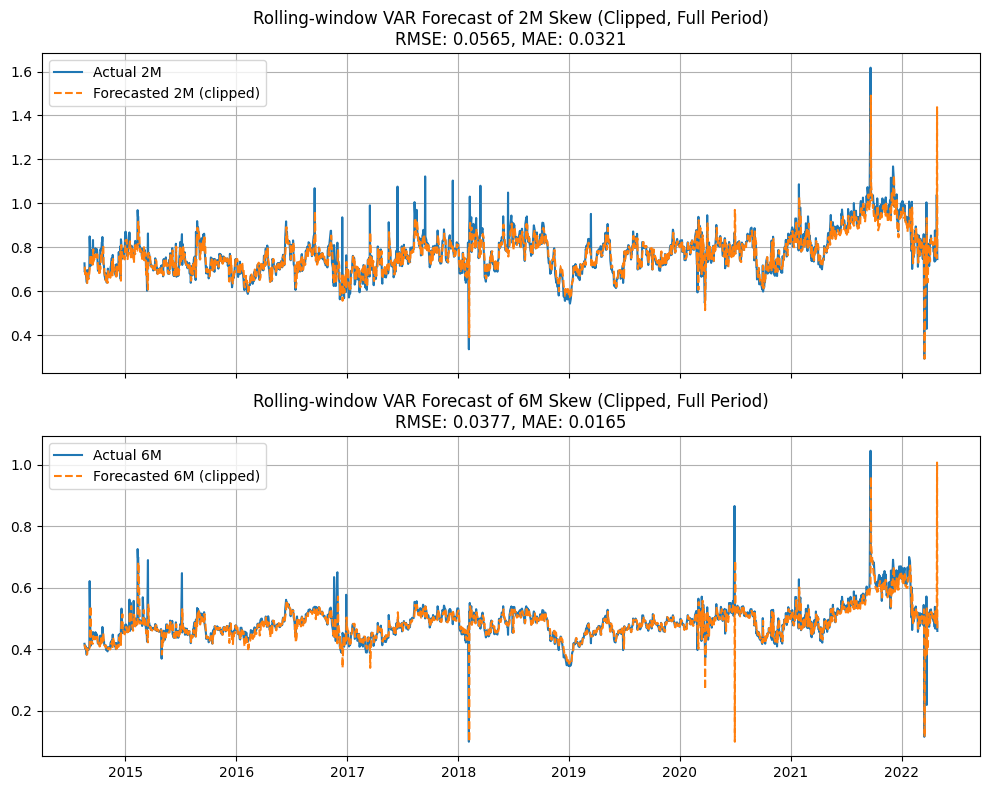

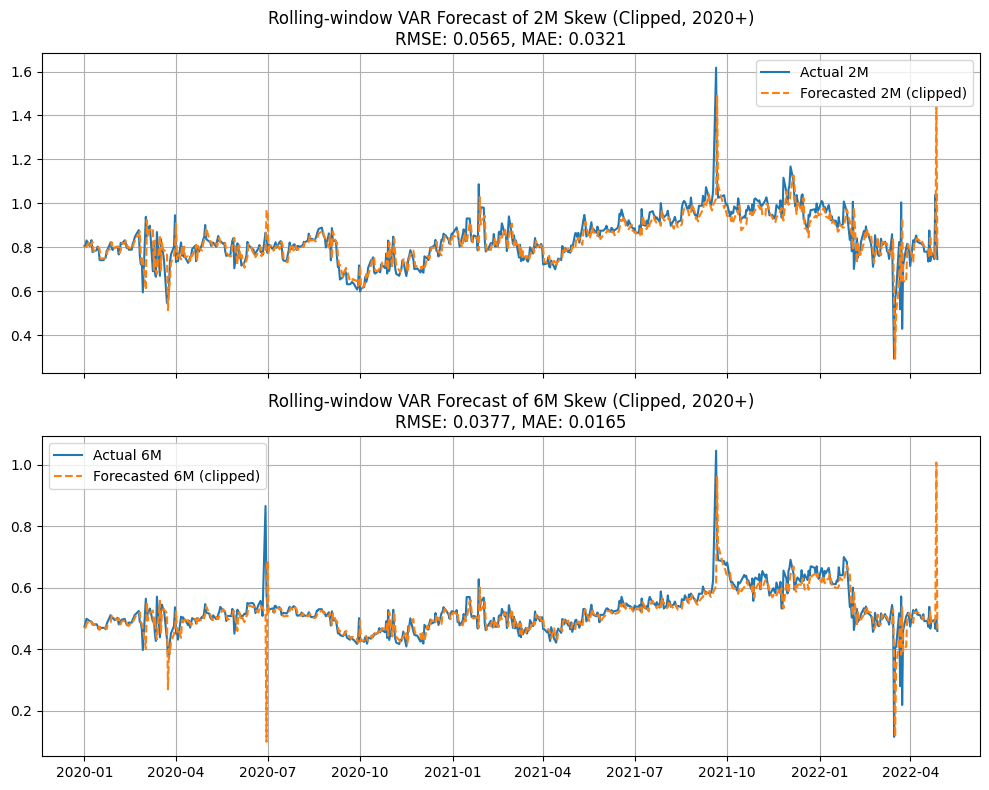

In [66]:
# 1. Assume df_spx_ts is already loaded and indexed by date
def test_stationarity(series, signif=0.05):
    result = adfuller(series.dropna())
    return result[1] < signif

# 2. Difference non-stationary series and drop NaNs
diffed = pd.DataFrame({
    col: (df_spx_ts[col] if test_stationarity(df_spx_ts[col]) 
          else df_spx_ts[col].diff())
    for col in df_spx_ts.columns
}, index=df_spx_ts.index)
diffed.dropna(inplace=True)

# 3. Choose a fixed lag order on an initial window
def select_initial_lag(data, maxlags=5):
    try:
        sel = VAR(data).select_order(maxlags=maxlags)
        return int(sel.aic)
    except Exception:
        return 1

initial_window = diffed.iloc[:750]
fixed_lag = select_initial_lag(initial_window)
print(f"Fixed rolling-window lag = {fixed_lag}")

# 4. In-sample performance on initial window
res_init = VAR(initial_window).fit(fixed_lag)
fitted = pd.DataFrame(
    res_init.fittedvalues,
    index=initial_window.index[fixed_lag:],
    columns=diffed.columns
)
data_in = initial_window.iloc[fixed_lag:]
ss_res = ((data_in - fitted)**2).sum()
ss_tot = ((data_in - data_in.mean())**2).sum()
nobs = data_in.shape[0]
iK = diffed.shape[1]
n_params = iK * fixed_lag + 1
r2 = 1 - ss_res/ss_tot
r2_adj = 1 - (1 - r2) * (nobs - 1) / (nobs - n_params - 1)
in_sample_perf = pd.DataFrame({'R2': r2, 'R2_adj': r2_adj})
print("\nIn-sample performance (initial window):")
print(in_sample_perf)

# 5. Rolling-window estimation & one-step forecast for ALL maturities
window_size = 750
cols = list(diffed.columns)
dates, preds, actuals = [], [], []

for t in range(window_size, len(diffed)):
    window_data = diffed.iloc[t-window_size:t]
    dates.append(diffed.index[t])
    actuals.append(diffed.iloc[t].values)
    try:
        res = VAR(window_data).fit(fixed_lag)
        fc = res.forecast(window_data.values[-fixed_lag:], steps=1)[0]
    except Exception:
        fc = window_data.values[-1]
    # clip to in-window min/max for each series
    mins = window_data.min().values
    maxs = window_data.max().values
    preds.append(np.clip(fc, mins, maxs))

# Build DataFrames of forecasts vs actuals
idx = pd.to_datetime(dates)
df_preds_all   = pd.DataFrame(preds,   index=idx, columns=cols)
df_actuals_all = pd.DataFrame(actuals, index=idx, columns=cols)

# 6. Build rolling-window error tables for 2M and 6M (unchanged)
df_errors_2M = pd.DataFrame({
    'Actual_2M':   df_actuals_all['2M'],
    'Forecast_2M': df_preds_all['2M']
}, index=idx)
df_errors_2M['Error_2M']    = df_errors_2M['Actual_2M'] - df_errors_2M['Forecast_2M']
df_errors_2M['AbsError_2M'] = df_errors_2M['Error_2M'].abs()
df_errors_2M['SqError_2M']  = df_errors_2M['Error_2M']**2

df_errors_6M = pd.DataFrame({
    'Actual_6M':   df_actuals_all['6M'],
    'Forecast_6M': df_preds_all['6M']
}, index=idx)
df_errors_6M['Error_6M']    = df_errors_6M['Actual_6M'] - df_errors_6M['Forecast_6M']
df_errors_6M['AbsError_6M'] = df_errors_6M['Error_6M'].abs()
df_errors_6M['SqError_6M']  = df_errors_6M['Error_6M']**2

df_errors_combined = pd.concat([df_errors_2M, df_errors_6M], axis=1)
print("\nSample of rolling-window errors for 2M and 6M:")
print(df_errors_combined.head())

# 7. Out-of-sample summary metrics FOR ALL MATURITIES
df_err_all     = df_actuals_all - df_preds_all
df_abs_err_all = df_err_all.abs()
df_sq_err_all  = df_err_all**2

rmse = np.sqrt(df_sq_err_all.mean())
mae  = df_abs_err_all.mean()

# keep 2M/6M variables for your existing prints
e_rmse_2M = rmse['2M']
e_mae_2M  = mae['2M']
e_rmse_6M = rmse['6M']
e_mae_6M  = mae['6M']

out_sample_perf = pd.DataFrame({
    'RMSE': rmse,
    'MAE':  mae
})

print("\nOut-of-sample summary metrics:")
print(out_sample_perf)

# still print formatted 2M/6M lines
print(f"\n2M RMSE: {e_rmse_2M:.4f}, MAE: {e_mae_2M:.4f}")
print(f"6M RMSE: {e_rmse_6M:.4f}, MAE: {e_mae_6M:.4f}")

# 8. Plot Actual vs Forecast for full out-of-sample period for 2M and 6M
fig_full, (ax1_full, ax2_full) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1_full.plot(df_errors_2M.index, df_errors_2M['Actual_2M'], label='Actual 2M')
ax1_full.plot(df_errors_2M.index, df_errors_2M['Forecast_2M'], '--', label='Forecasted 2M (clipped)')
ax1_full.set_title(f'Rolling-window VAR Forecast of 2M Skew (Clipped, Full Period)\n'
                   f'RMSE: {e_rmse_2M:.4f}, MAE: {e_mae_2M:.4f}')
ax1_full.legend(); ax1_full.grid(True)

ax2_full.plot(df_errors_6M.index, df_errors_6M['Actual_6M'], label='Actual 6M')
ax2_full.plot(df_errors_6M.index, df_errors_6M['Forecast_6M'], '--', label='Forecasted 6M (clipped)')
ax2_full.set_title(f'Rolling-window VAR Forecast of 6M Skew (Clipped, Full Period)\n'
                   f'RMSE: {e_rmse_6M:.4f}, MAE: {e_mae_6M:.4f}')
ax2_full.legend(); ax2_full.grid(True)

plt.tight_layout()
plt.show()

# 9. Plot Actual vs Forecast from 2020+ for 2M and 6M
results_2020_2M = df_errors_2M.loc['2020-01-01':]
results_2020_6M = df_errors_6M.loc['2020-01-01':]

fig_2020, (ax1_2020, ax2_2020) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1_2020.plot(results_2020_2M.index, results_2020_2M['Actual_2M'], label='Actual 2M')
ax1_2020.plot(results_2020_2M.index, results_2020_2M['Forecast_2M'], '--',
               label='Forecasted 2M (clipped)')
ax1_2020.set_title(f'Rolling-window VAR Forecast of 2M Skew (Clipped, 2020+)\n'
                   f'RMSE: {e_rmse_2M:.4f}, MAE: {e_mae_2M:.4f}')
ax1_2020.legend(); ax1_2020.grid(True)

ax2_2020.plot(results_2020_6M.index, results_2020_6M['Actual_6M'], label='Actual 6M')
ax2_2020.plot(results_2020_6M.index, results_2020_6M['Forecast_6M'], '--',
               label='Forecasted 6M (clipped)')
ax2_2020.set_title(f'Rolling-window VAR Forecast of 6M Skew (Clipped, 2020+)\n'
                   f'RMSE: {e_rmse_6M:.4f}, MAE: {e_mae_6M:.4f}')
ax2_2020.legend(); ax2_2020.grid(True)

plt.tight_layout()
plt.show()

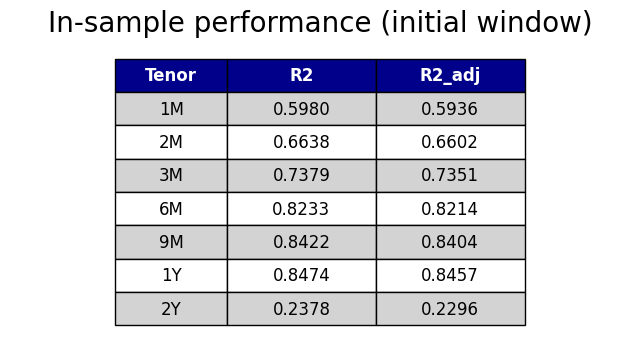

In [67]:
# Assume in_sample_perf is already defined as a DataFrame with tenors as index
# Prepare data for the table
table_data = in_sample_perf.values
table_data = [[f"{val:.4f}" for val in row] for row in table_data]  # Format numbers to 4 decimal places
table_data = [[tenor] + list(row) for tenor, row in zip(in_sample_perf.index, table_data)]  # Add tenors as the first column
col_labels = ["Tenor"] + in_sample_perf.columns.tolist()  # Include "Tenor" in the header

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.axis("off")

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc="center",
    loc="center",
    colColours=["darkblue"] * len(col_labels),
    colWidths=[0.15] + [0.2] * (len(col_labels) - 1)  # Adjust column widths
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)  # Adjust table size
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header
        cell.set_text_props(color="white", weight="bold")
        cell.set_facecolor("darkblue")
    else:  # Cells
        cell.set_facecolor("lightgrey" if (i - 1) % 2 == 0 else "white")

# Add title
plt.title("In-sample performance (initial window)", fontsize=20, pad=5)

# Save the plot to a file
plt.savefig('in_sample_var_performance.png', bbox_inches="tight", dpi=300)

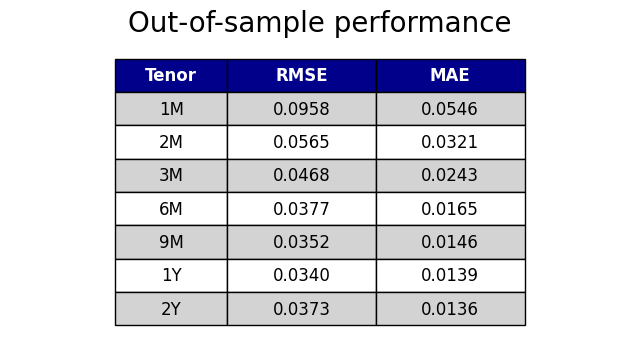

In [68]:
# Assume out_sample_perf is already defined as a DataFrame with tenors as index
# Prepare data for the table
table_data = out_sample_perf.values
table_data = [[f"{val:.4f}" for val in row] for row in table_data]  # Format numbers to 4 decimal places
table_data = [[tenor] + list(row) for tenor, row in zip(out_sample_perf.index, table_data)]  # Add tenors as the first column
col_labels = ["Tenor"] + out_sample_perf.columns.tolist()  # Include "Tenor" in the header

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.axis("off")

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc="center",
    loc="center",
    colColours=["darkblue"] * len(col_labels),
    colWidths=[0.15] + [0.2] * (len(col_labels) - 1)  # Adjust column widths
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)  # Adjust table size
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header
        cell.set_text_props(color="white", weight="bold")
        cell.set_facecolor("darkblue")
    else:  # Cells
        cell.set_facecolor("lightgrey" if (i - 1) % 2 == 0 else "white")

# Add title
plt.title("Out-of-sample performance", fontsize=20, pad=5)

# Save the plot to a file
plt.savefig('out_sample_var_performance.png', bbox_inches="tight", dpi=300)